## Detecting marine heatwaves (1D data) : tutorial
This is a short tutorial showing how to use the [marineHeatWaves](https://github.com/ecjoliver/marineHeatWaves) package to detect marine heat waves in model data.  In this first example, we extract a 1-dimensional time-series of surface temperatures at a specific location. Further tutorials will explore how to work with 3D (lat-lon-time) data.  

This tutorial follows the basic example in the marineHeatWaves package, which can be found [here](https://github.com/ecjoliver/marineHeatWaves/blob/master/docs/example_synthetic.ipynb), but deals with some intricacies associated with the model data, particularly the time coordinate. It is also written in a more `xarray`-oriented fashion, anticipating that this will ultimately be useful when working with 3D data, although it is not essential at this stage.

Throughout, we will use the default setting of the marineHeatWaves package.

In [1]:
# Import some useful packages
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
from datetime import date
import cftime
import matplotlib.pyplot as plt

# Import the marineHeatWaves package
import marineHeatWaves as mhw

ModuleNotFoundError: No module named 'marineHeatWaves'

In [ ]:
# Specify the path to the data on oahu
# Here, I specify the main "postprocess" path, which ends with the folder "pp"
rootdir = ('/local/data/GFDL_simulations/ESM4_PPE/'+
           'ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/'+
           'pp/')
# Then, I say which subset of postprocessed data 
# (different types of variables are sstored in different folders, 
# e.g. ocean physical variables like tmperature, or biogeochemical variables
# like chlorophyll)
ppname = 'ocean_daily'
# Finally I specify some details of the local directory
localdir = "/ts/daily/5yr/"
# Now specify the name of the file you want to open
# NOTE that the filenames always start with the same ppname,
# so I can save some hassle here...
# Use wildcards to grab the first 60 years
filename = ppname+'.01[012345][16]0101-01[0123456][50]1231.tos.nc'

# The combination of all these defines the path
path = rootdir+ppname+localdir+filename

# Load the file using xarray
ds = xr.open_mfdataset(path)
# For memory reasons, we are going to "chunk" the data in the time dimension
ds = ds.chunk({'time':365,'yh':96})

### Subset data
Select a single latitude and longitude (note that we are doing this with the "nominal" coordinate here, so it is not 100% accurate for that location (see discussion in the plotting geodata tutorial). However, it is good enough for our purposes.  

We will also load/compute the data into memory here, which may take several minutes.

In [2]:
# Pick a spot in the Atlantic, on the equator
tos = ds['tos'].sel(xh=-20,yh=0,method='nearest')
with ProgressBar():
    tos = tos.compute()

NameError: name 'ds' is not defined

In [3]:
# Quick check of what the time-series looks like
tos.plot(figsize=(8,3))

NameError: name 'tos' is not defined

### Dealing with the time variables
The marineHeatWaves package is set up to accept "ordinal" dates from the Gregorian calendar. That is, January 1 of year 0001 has ordinal date 1, January 2 of year 0002 has ordinal date 2, and so on.  

The model data that we are working with uses a NoLeapYear calendar, which we can convert to ordinal days using the `cftime` package. It is worth noting that this means there is a mismatch between our handling of the time array, and the way that marineHeatWaves handles the time array (where the latter assumes that the ordinal time corresponds to a standard Gregorian Calendar). This should not result in any issues, but is just worth keeping in mind when looking at the marineHeatWaves output (for example, the `date_start` and `date_end` variables will not match the actual model dates).  

We will ultimately work with two time arrays:
- the `time` variable in the loaded dataset, which is a `cftime` object
- the `otimes` variable that we will create now, which is an ordinal time, and is used to interface with the marineHeatWaves package

In [5]:
# Create an array of ordinal times
otimes = cftime.date2num(ds['time'].values,units='days since 0001-01-01-12:00:00',calendar='noleap')

## Detect MHWs
Use the `detect` function from marineHeatWaves to detect all of the events that match their criteria.

In [6]:
mhws, clim = mhw.detect(otimes, tos.values)

### Take a look at some of the output
Information about the MHWs is stored in `mhws`, whereas climatological information about our times series is stored in `clim`.  

`mhws` is a *dictionary* with a number of `keys`, each one corresponding to a dictionary `item`, which has some information about the MHWs that we've detected. Most of these `items` have an array of length `n_events` (a parameter that is also given in `mhws`), which is the number of detected events.  

In [7]:
mhws.keys()

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])

In [8]:
mhws['n_events']

158

We can actually make life a little simpler for ourselves (and consistent with our workflow) by piping `mhws` into an xarray dataset.

In [9]:
eva = np.arange(1,mhws['n_events']+1) # Create an array of indices for the events
xm = xr.Dataset(coords={'ev':eva})
for key,value in mhws.items():
    xm[key]=xr.DataArray(value,dims=['ev'],coords={'ev':eva})
# Don't need to keep the 'n_events' variable
xm = xm.drop('n_events')

In [10]:
# Now we can take a look at that 
xm

<xarray.Dataset>
Dimensions:                         (ev: 158)
Coordinates:
  * ev                              (ev) int64 1 2 3 4 5 ... 154 155 156 157 158
Data variables: (12/29)
    time_start                      (ev) int64 36602 36641 36651 ... 57643 57745
    time_end                        (ev) int64 36613 36646 36656 ... 57653 57749
    time_peak                       (ev) int64 36609 36644 36655 ... 57650 57749
    date_start                      (ev) object 0101-03-19 ... 0159-02-06
    date_end                        (ev) object 0101-03-30 ... 0159-02-10
    date_peak                       (ev) object 0101-03-26 ... 0159-02-10
    ...                              ...
    intensity_mean_abs              (ev) float32 30.37 28.65 ... 28.01 30.58
    intensity_var_abs               (ev) float32 0.2129 0.1101 ... 0.2484 0.1637
    intensity_cumulative_abs        (ev) float32 364.5 171.9 ... 308.2 152.9
    category                        (ev) <U8 'Moderate' ... 'Moderate'
    rate_onset                      (ev) float64 0.1155 0.1127 ... 0.1219 0.1106
    rate_decline                    (ev) float64 0.1765 0.1034 ... 0.2388 0.6382

In [11]:
# Do the same for the climatology
xc = xr.Dataset(coords={'time':tos['time']})
for key,value in clim.items():
    xc[key]=xr.DataArray(value,dims=['time'],coords={'time':tos['time']})

In [12]:
xc

<xarray.Dataset>
Dimensions:  (time: 21900)
Coordinates:
    xh       float64 -19.75
    yh       float64 -0.0
  * time     (time) object 0101-01-01 12:00:00 ... 0160-12-31 12:00:00
Data variables:
    thresh   (time) float64 27.67 27.69 27.73 27.76 ... 27.43 27.43 27.43 27.44
    seas     (time) float64 26.79 26.8 26.82 26.85 ... 26.61 26.61 26.62 26.62
    missing  (time) bool False False False False ... False False False False

Let's take a look at some of the attributes of the most extreme MHW over the time-series.

In [13]:
evmax = xm['intensity_max'].argmax(dim='ev') # Find largest event
# Select this extreme event
ex = xm.isel(ev=evmax)
# Print some of its attributes
print('Maximum intensity:', ex['intensity_max'].values, 'deg. C')
print('Average intensity:', ex['intensity_mean'].values, 'deg. C')
print('Cumulative intensity:', ex['intensity_cumulative'].values, 'deg. C-days')
print('Duration:', ex['duration'].values, 'days')
# Note that if we want the date, we have to grab it from the original time array using the 
# index returned by the package (rather than using the date_start/end attributes)
das = tos['time'].isel(time=ex['index_start'])
print('Start date:', das.values)
dae = tos['time'].isel(time=ex['index_end'])
print('End date:', dae.values)

### Just to check, take a look at the difference in dates output by marineHeatWaves
print(' ')
print('Note the difference to dates derived in marineHeatWaves:')
print('Start date:', mhws['date_start'][int(evmax)].strftime("%d %B %Y"))
print('End date:', mhws['date_end'][int(evmax)].strftime("%d %B %Y"))

Maximum intensity: 3.6664487161943953 deg. C
Average intensity: 2.209853833225342 deg. C
Cumulative intensity: 137.0109376599712 deg. C-days
Duration: 62 days
Start date: 0144-09-10 12:00:00
End date: 0144-11-10 12:00:00
 
Note the difference to dates derived in marineHeatWaves:
Start date: 05 August 144
End date: 05 October 144


### Now plot some data

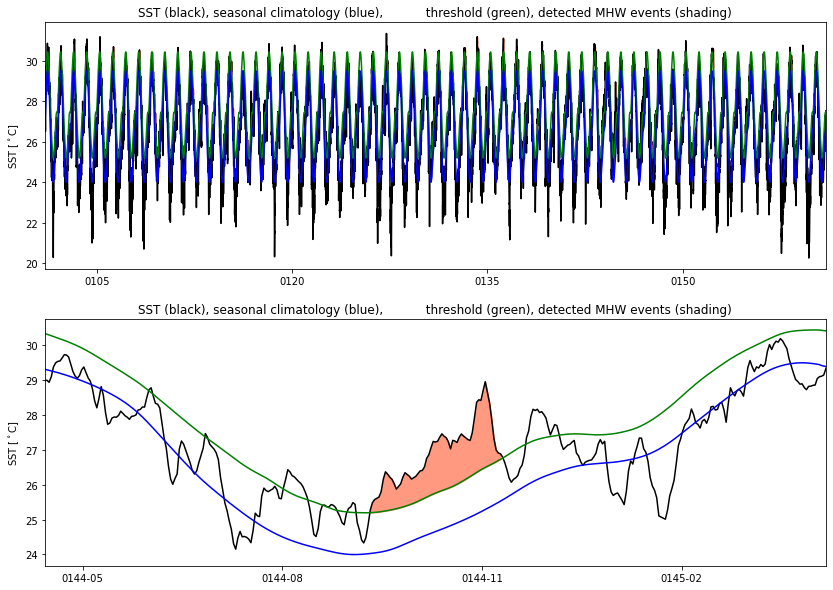

In [14]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(tos['time'], tos, 'k-')
plt.plot(xc['time'], xc['thresh'], 'g-')
plt.plot(xc['time'], xc['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel(r'SST [$^\circ$C]')
# Find indices for all MHWs and shade accordingly
for evnow in range(len(xm['ev'])):
    # Get the attributes for the event
    xmnow = xm.isel(ev=evnow)
    i1 = int(xmnow['index_start'])
    i2 = int(xmnow['index_end'])
    # Select the temperature timeseries and the climatology during the event
    tos_ev = tos.isel(time=slice(i1,i2))
    xc_ev = xc.isel(time=slice(i1,i2))
    # Shade between these lines using the .fill_between function
    plt.fill_between(tos_ev['time'].values, tos_ev, xc_ev['thresh'], \
                     color=(1,0.6,0.5))

# Now zoom in on the most extreme event
plt.subplot(2,1,2) # Add a subplot
# Get the event index
evnow = evmax

# As above, Get the attributes for the event
xmnow = xm.isel(ev=evnow)
i1 = int(xmnow['index_start'])
i2 = int(xmnow['index_end'])
# Select the temperature timeseries and the climatology during the event
tos_ev = tos.isel(time=slice(i1,i2))
xc_ev = xc.isel(time=slice(i1,i2))
# Shade between these lines using the .fill_between function
plt.fill_between(tos_ev['time'].values, tos_ev, xc_ev['thresh'], \
                 color=(1,0.6,0.5))
# Now get the temperature and climatology for a time period of ~1 year **around** the event
# And plot them
tos_evplus = tos.isel(time=slice(i1-150,i2+150))
xc_evplus = xc.isel(time=slice(i1-150,i2+150))
plt.plot(tos_evplus['time'], tos_evplus, 'k-')
plt.plot(xc_evplus['time'], xc_evplus['thresh'], 'g-')
plt.plot(xc_evplus['time'], xc_evplus['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.ylabel(r'SST [$^\circ$C]')
plt.autoscale(enable=True, axis='x', tight=True)